In [1]:
from __future__ import division, print_function

# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm  # Colormaps
from matplotlib.colors import LogNorm  # Log colormaps
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
#import seaborn

In [2]:
# Define plotting functions
def get_cost_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws, cost_func):
    """Define a vector of weights for which we want to plot the cost."""
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)  # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)  # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)  # Generate grid
    cost_ws = np.zeros((nb_of_ws, nb_of_ws))  # Initialize cost matrix
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            cost_ws[i,j] = cost_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, cost_ws

def plot_surface(ax, ws1, ws2, cost_ws):
    """Plot the cost in function of the weights."""
    surf = ax.contourf(ws1, ws2, cost_ws, levels=np.logspace(-0.2, 8, 30), cmap=cm.pink, norm=LogNorm())
    ax.set_xlabel('$U$', fontsize=15)
    ax.set_ylabel('$W$', fontsize=15)
    return surf

def plot_points(ax, points):
    """Plot the annotation points on the given axis."""
    for wx, wRec, c in points:
        ax.plot(wx, wRec, c+'o', linewidth=2)

def get_cost_surface_figure(cost_func, points):
    """Plot the cost surfaces together with the annotated points."""
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    plot_points(ax_1, points)
    ax_1.set_xlim(-3, 3)
    ax_1.set_ylim(-3, 3)
    # Plot zoom of cost function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, cost_ws_2 = get_cost_surface(0, 2, 0, 2, 100, cost_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2 + 1)
    plot_points(ax_2, points)
    ax_2.set_xlim(0, 2)
    ax_2.set_ylim(0, 2)
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15, rotation=0, labelpad=20)
    cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    fig.suptitle('Cost surface', fontsize=15)
    return fig

In [3]:
# Create dataset
nb_of_samples = 50
sequence_len = 10
# Create the sequences
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Create the targets for each sequence
t = np.sum(X, axis=1)

print('X: ', X[0,:])
print('t: ', t[0])

X:  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
t:  2.0


In [4]:
def forward(X, U, W):
    """
    Unfold the network and compute all state activations given the input X,
    and input weights (wx) and recursive weights (wRec).
    Return the state activations in a matrix, the last column S[:,-1] contains the
    final activations.
    """
    # Initialise the matrix that holds all states for all input sequences.
    # The initial state s0 is set to 0.
    S = np.zeros((nb_of_samples, sequence_len+1))
    # Update the states over the sequence
    for k in range(0, sequence_len):
        S[:,k+1] = X[:,k] * U + S[:,k] * W
    return S

def cost(y, t):
    """
    Return the MSE between the targets t and the outputs y.
    """
    return np.sum((t - y)**2)

def backward(X, S, t, W):
    """
    Backpropagate the gradient computed at the output (grad_out) through the network.
    Accumulate the parameter gradients for wX and wRec by for each layer by addition.
    Return the parameter gradients as a tuple, and the gradients at the output of each layer.
    """
    # Output `y` is last activation of sequence
    y = S[:,-1]
    # Gradient w.r.t. cost function at final state
    gS_k = 2.0 * (y - t)
    # Set the gradient accumulations to 0
    gU, gW = 0, 0
    # Accumulate gradients backwards
    for k in range(sequence_len, 0, -1):
        # Compute the parameter gradients and accumulate the results.
        gU += np.sum(gS_k * X[:,k-1])
        gW += np.sum(gS_k * S[:,k-1])
        # Compute the gradient at the output of the previous layer
        gS_k = gS_k * W
    return gU, gW

In [5]:
# Perform gradient checking
# Set the weight parameters used during gradient checking
params = [1.2, 1.2]  # [U, W]
# Set the small change to compute the numerical gradient
eps = 1e-7
# Compute the backprop gradients
S = forward(X, params[0], params[1])
backprop_grads = backward(X, S, t, params[1])
# Compute the numerical gradient for each parameter in the layer
for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    params[p_idx] += eps
    plus_cost = cost(forward(X, params[0], params[1])[:,-1], t)
    # - eps
    params[p_idx] -= 2 * eps
    min_cost = cost(forward(X, params[0], params[1])[:,-1], t)
    # reset param value
    params[p_idx] += eps
    # calculate numerical gradient
    grad_num = (plus_cost - min_cost) / (2*eps)
    # Raise error if the numerical grade is not close to the backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


In [6]:
# Perform gradient descent

# Set hyperparameters
lr = 0.0005

# Set initial parameters
params = [-2, 0]  # [U, W]

ls_of_ws = [(params[0], params[1])]  # List of weights to plot
ls_of_costs = [cost(forward(X, params[0], params[1])[:,-1], t)]
ls_of_gW = []
# Iterate over 500 iterations
for i in range(500):
    # Perform forward and backward pass to get the gradients
    S = forward(X, params[0], params[1])
    gparams = backward(X, S, t, params[1])
    ls_of_gW.append(gparams[1])
    # Get the update values and sign of the last gradient
    params = [(p - gp * lr) for p, gp in zip(params, gparams)]
    c = cost(forward(X, params[0], params[1])[:,-1], t)
    ls_of_costs.append(c)
    ls_of_ws.append((params[0], params[1]))  # Add weights to list to plot

print('Final weights are: wx = {0},  wRec = {1}'.format(params[0], params[1]))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: overflow encountered in multiply
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: overflow encountered in square
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: overflow encountered in multiply
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply


Final weights are: wx = nan,  wRec = nan


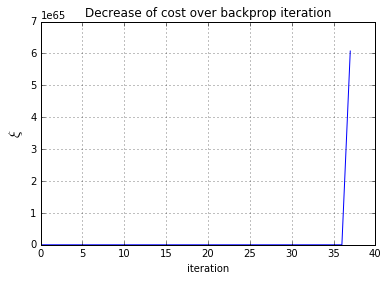

In [7]:
# Plot the cost over the iterations
plt.plot(ls_of_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

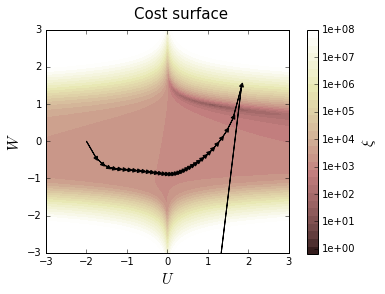

In [8]:
# Plot the cost surface with the weights over the iterations.

# Define plot function
def plot_optimisation(ls_of_ws, cost_func):
    """Plot the optimisation iterations on the cost surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(5, 4))
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,1,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    for i in xrange(1, 38):#len(ws1)):
        #print(i, ws1[i-1], ws2[i-1])
        ax_1.arrow(ws1[i-1], ws2[i-1], ws1[i]-ws1[i-1], ws2[i]-ws2[i-1], 
                   head_width=0.1, head_length=0.1, fc='k', ec='k')
    #ax_1.plot(ws1, ws2, 'b.-')
    ax_1.set_xlim([-3,3])
    ax_1.set_ylim([-3,3])
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15)
    cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Cost surface', fontsize=15)
    plt.show()

# Plot the optimisation
plot_optimisation(ls_of_ws, lambda w1, w2: cost(forward(X, w1, w2)[:,-1] , t))
plt.show()

In [15]:
# Perform Rprop optimisation

# Set hyperparameters
eta_p = 1.2
eta_n = 0.5

# Set initial parameters
params = [-1.5, 2]  # [U, W]
params_delta = [0.001, 0.001]  # Update values (Delta) for W
params_sign = [0, 0]  # Previous sign of W

ls_of_ws = [(params[0], params[1])]  # List of weights to plot
ls_of_costs = [cost(forward(X, params[0], params[1])[:,-1], t)]
ls_of_gW = []
# Iterate over 500 iterations
for i in range(500):
    # Perform forward and backward pass to get the gradients
    S = forward(X, params[0], params[1])
    gparams = backward(X, S, t, params[1])
    ls_of_gW.append(gparams[1])
    params_sign_new = np.sign(gparams)  # Sign of new gradient
    # Get the update values and sign of the last gradient
    # Update the Delta (update value) for each weight parameter seperately
    params_delta = [
        (pd * eta_p) if psn == ps else (pd * eta_n)
        for pd, psn, ps in zip(params_delta, params_sign_new, params_sign)]
    params_sign = params_sign_new
    # Update each weight parameter seperately
    for i, _ in enumerate(params):
        params[i] -= params_sign[i] * params_delta[i]
    c = cost(forward(X, params[0], params[1])[:,-1], t)
    ls_of_costs.append(c)
    ls_of_ws.append((params[0], params[1]))  # Add weights to list to plot

print('Final weights are: wx = {0},  wRec = {1}'.format(params[0], params[1]))

Final weights are: wx = 1.000278165,  wRec = 0.999937053652


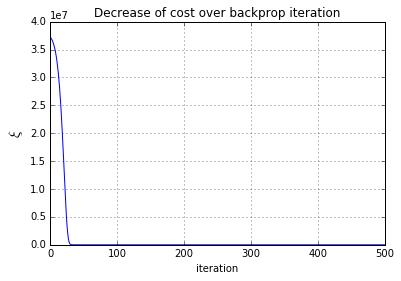

In [16]:
# Plot the cost over the iterations
plt.plot(ls_of_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

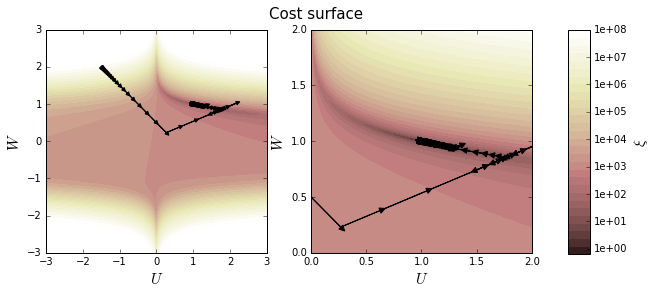

In [17]:
# Plot the cost surface with the weights over the iterations.

# Define plot function
def plot_optimisation(ls_of_ws, cost_func):
    """Plot the optimisation iterations on the cost surface."""
    ws1, ws2 = zip(*ls_of_ws)
    # Plot figures
    fig = plt.figure(figsize=(10, 4))
    # Plot overview of cost function
    ax_1 = fig.add_subplot(1,2,1)
    ws1_1, ws2_1, cost_ws_1 = get_cost_surface(-3, 3, -3, 3, 100, cost_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, cost_ws_1 + 1)
    for i in xrange(1, len(ws1)):
        ax_1.arrow(ws1[i-1], ws2[i-1], ws1[i]-ws1[i-1], ws2[i]-ws2[i-1], 
                   head_width=0.1, head_length=0.1, fc='k', ec='k')
    #ax_1.plot(ws1, ws2, 'b.-')
    ax_1.set_xlim([-3,3])
    ax_1.set_ylim([-3,3])
    # Plot zoom of cost function
    ax_2 = fig.add_subplot(1,2,2)
    ws1_2, ws2_2, cost_ws_2 = get_cost_surface(0, 2, 0, 2, 100, cost_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2 + 1)
    ax_2.set_xlim([0,2])
    ax_2.set_ylim([0,2])
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, cost_ws_2)
    for i in xrange(1, len(ws1)):
        ax_2.arrow(ws1[i-1], ws2[i-1], ws1[i]-ws1[i-1], ws2[i]-ws2[i-1], 
               head_width=0.05, head_length=0.05, fc='k', ec='k')
    #ax_2.plot(ws1, ws2, 'b.-')
    # Show the colorbar
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.12, 0.03, 0.78])
    cbar = fig.colorbar(surf_1, ticks=np.logspace(0, 8, 9), cax=cax)
    cbar.ax.set_ylabel('$\\xi$', fontsize=15)
    cbar.set_ticklabels(['{:.0e}'.format(i) for i in np.logspace(0, 8, 9)])
    plt.suptitle('Cost surface', fontsize=15)
    plt.show()

# Plot the optimisation
plot_optimisation(ls_of_ws, lambda w1, w2: cost(forward(X, w1, w2)[:,-1] , t))
plt.show()